In [2]:
pip install linearmodels

     |████████████████████████████████| 1.5 MB 7.8 MB/s 
     |████████████████████████████████| 9.8 MB 30.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

from matplotlib import rcParams

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import os
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf 
from sklearn.decomposition import PCA
import seaborn as sns
import statsmodels.api as sm
from linearmodels import PooledOLS, PanelOLS

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
x = ['sensor_' + str(i) for i in range(1, 22)]
col_names = ['unit_number', 'time_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + x

In [6]:
train_01 = pd.read_csv('/content/drive/My Drive/Booz_Allen/CMAPSSData/train_FD001.txt', delim_whitespace=True, header = None, names = col_names)
train_02 = pd.read_csv('/content/drive/My Drive/Booz_Allen/CMAPSSData/train_FD002.txt', delim_whitespace=True, header = None, names = col_names)
train_03 = pd.read_csv('/content/drive/My Drive/Booz_Allen/CMAPSSData/train_FD003.txt', delim_whitespace=True, header = None, names = col_names)
train_04 = pd.read_csv('/content/drive/My Drive/Booz_Allen/CMAPSSData/train_FD004.txt', delim_whitespace=True, header = None, names = col_names)

In [7]:
test_01 = pd.read_csv('/content/drive/My Drive/Booz_Allen/CMAPSSData/test_FD001.txt', delim_whitespace=True, header = None, names = col_names)
test_02 = pd.read_csv('/content/drive/My Drive/Booz_Allen/CMAPSSData/test_FD002.txt', delim_whitespace=True, header = None, names = col_names)
test_03 = pd.read_csv('/content/drive/My Drive/Booz_Allen/CMAPSSData/test_FD003.txt', delim_whitespace=True, header = None, names = col_names)
test_04 = pd.read_csv('/content/drive/My Drive/Booz_Allen/CMAPSSData/test_FD004.txt', delim_whitespace=True, header = None, names = col_names)

In [8]:
rul_01 = pd.read_csv('/content/drive/My Drive/Booz_Allen/CMAPSSData/RUL_FD001.txt', delim_whitespace=True, header = None)
rul_02 = pd.read_csv('/content/drive/My Drive/Booz_Allen/CMAPSSData/RUL_FD002.txt', delim_whitespace=True, header = None)
rul_03 = pd.read_csv('/content/drive/My Drive/Booz_Allen/CMAPSSData/RUL_FD003.txt', delim_whitespace=True, header = None)
rul_04 = pd.read_csv('/content/drive/My Drive/Booz_Allen/CMAPSSData/RUL_FD004.txt', delim_whitespace=True, header = None)

In [9]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_number")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_number', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train_01 = add_remaining_useful_life(train_01)
train_01.head()

,unit_number,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [10]:
train_01 = train_01.set_index(["unit_number", "time_cycles"])

In [11]:
x = ['sensor_' + str(i) for i in range(1, 14)]

In [12]:
exog_vars = ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 
             'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 
             'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']
exog = sm.add_constant(train_01[exog_vars])
mod = PooledOLS(train_01[['RUL']], exog, check_rank = False)
pooled_res = mod.fit(cov_type='clustered', cluster_entity=True)
print(pooled_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:                    RUL   R-squared:                        0.5796
Estimator:                  PooledOLS   R-squared (Between):             -0.4764
No. Observations:               20631   R-squared (Within):               0.7222
Date:                Tue, Nov 16 2021   R-squared (Overall):              0.5796
Time:                        14:33:03   Log-likelihood                -1.077e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1894.4
Entities:                         100   P-value                           0.0000
Avg Obs:                       206.31   Distribution:                F(15,20615)
Min Obs:                       128.00                                           
Max Obs:                       362.00   F-statistic (robust):             78.192
                            

In [13]:
fittedvals_pooled_OLS = pooled_res.predict().fitted_values
residuals_pooled_OLS = pooled_res.resids

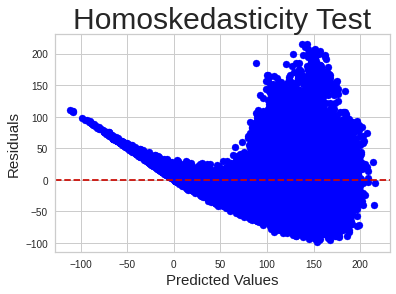

In [14]:
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

In [15]:
# 3A.2 White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset = pd.concat([train_01, residuals_pooled_OLS], axis=1)
exog = sm.tools.tools.add_constant(train_01[x]).fillna(0)
#white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
#print(dict(zip(labels, white_test_results)))
# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

{'LM-Stat': 765.6633002753355, 'LM p-val': 3.800836154484834e-156, 'F-Stat': 79.47500457868524, 'F p-val': 4.175051618788453e-161}


In [16]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
print(durbin_watson_test_results)


0.08742242851917914


In [17]:
# FE und RE model
from linearmodels import PanelOLS
from linearmodels import RandomEffects
exog = sm.tools.tools.add_constant(train_01[exog_vars])
endog = train_01[['RUL']]
# random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 
# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True) 
fe_res = model_fe.fit() 
#print results
print(re_res)
#print(fe_res)


                        RandomEffects Estimation Summary                        
Dep. Variable:                    RUL   R-squared:                        0.7364
Estimator:              RandomEffects   R-squared (Between):             -0.7824
No. Observations:               20631   R-squared (Within):               0.7388
Date:                Tue, Nov 16 2021   R-squared (Overall):              0.5509
Time:                        14:33:15   Log-likelihood                -1.014e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      3840.3
Entities:                         100   P-value                           0.0000
Avg Obs:                       206.31   Distribution:                F(15,20615)
Min Obs:                       128.00                                           
Max Obs:                       362.00   F-statistic (robust):             3845.6
                            

In [18]:
test_01 = test_01.sort_values(['unit_number', 'time_cycles']).drop_duplicates('unit_number', keep='last')

In [20]:
test_01 = test_01.set_index(["unit_number", "time_cycles"])

In [21]:
test_01.iloc[:, 3:]

,,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
unit_number,time_cycles,,,,,,,,,,,,,,,,,,,,,
1,31,518.67,642.58,1581.22,1398.91,14.62,21.61,554.42,2388.08,9056.40,1.3,47.23,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552
2,49,518.67,642.55,1586.59,1410.83,14.62,21.61,553.52,2388.10,9044.77,1.3,47.67,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618
3,126,518.67,642.88,1589.75,1418.89,14.62,21.61,552.59,2388.16,9049.26,1.3,47.88,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740
4,106,518.67,642.78,1594.53,1406.88,14.62,21.61,552.64,2388.13,9051.30,1.3,47.65,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581
5,98,518.67,642.27,1589.94,1419.36,14.62,21.61,553.29,2388.10,9053.99,1.3,47.46,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,97,518.67,642.30,1590.88,1397.94,14.62,21.61,553.99,2388.03,9062.41,1.3,47.14,522.30,2388.01,8148.24,8.4110,0.03,391,2388,100.0,38.96,23.4606
97,134,518.67,642.59,1582.96,1410.92,14.62,21.61,554.05,2388.06,9076.36,1.3,47.38,521.58,2388.06,8155.48,8.4500,0.03,395,2388,100.0,38.61,23.2953
98,121,518.67,642.68,1599.51,1415.47,14.62,21.61,553.44,2388.13,9062.34,1.3,47.66,521.53,2388.09,8146.39,8.4235,0.03,394,2388,100.0,38.76,23.3608


In [22]:
re_pred = re_res.predict(test_01[exog_vars])
np.sqrt(mean_squared_error(rul_01, re_pred))

32.475274667564456

In [25]:
mean_absolute_error(rul_01, re_pred)

25.240880416129677

In [23]:
re_pred

,,predictions
unit_number,time_cycles,
1,31,158.286489
2,49,114.495246
3,126,69.457128
4,106,87.065199
5,98,100.037553
...,...,...
96,97,176.218433
97,134,107.548292
98,121,92.684696


In [24]:
from google.colab import files
re_pred.to_csv('re_pred.csv')
files.download('re_pred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    RUL   R-squared:                        0.7388
Estimator:                   PanelOLS   R-squared (Between):             -0.8227
No. Observations:               20631   R-squared (Within):               0.7388
Date:                Wed, Nov 10 2021   R-squared (Overall):              0.5532
Time:                        16:52:38   Log-likelihood                -1.013e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      3869.5
Entities:                         100   P-value                           0.0000
Avg Obs:                       206.31   Distribution:                F(15,20516)
Min Obs:                       128.00                                           
Max Obs:                       362.00   F-statistic (robust):             3869.5
                            

In [ ]:
import numpy.linalg as la
from scipy import stats
import numpy as np
def hausman(fe, re):
  b = fe.params
  B = re.params
  v_b = fe.cov
  v_B = re.cov
  df = b[np.abs(b) < 1e8].size
  chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 
  pval = stats.chi2.sf(chi2, df)
  return chi2, df, pval

hausman_results = hausman(fe_res, re_res) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 11.969888324311839
degrees of freedom: 16
p-Value: 0.7460499889682672


In [ ]:
test_01 = test_01.sort_values(['unit_number', 'time_cycles']).drop_duplicates('unit_number', keep='last')